In [11]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
import entsoeAPI
import importlib
import DE_zipcode
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import geopandas as gpd
import random
importlib.reload(entsoeAPI)
importlib.reload(DE_zipcode)


def Germany_decision_regressor(xdata,ydata):
    """ 
    Decision regression to predict the renewable energy % in Germany
    
    Parameters:
    xdata:historical weather data with zip code information in Germany
    ydata:energy genertaion from 20220601 to 20230601 in Germany
    Returns: 
    print evaluation of the performance(mse, Root Mean Squared Error, R^2 Score)  
    the top 5 features
    plot comparing prediction of renewable energy % and actual renewable energy %
    
    """
    # Separate the features and the target variable
    X = xdata
    y = ydata['percentRenewableWS']

    # Split the dataset into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Initialize the Decision Tree Regressor
    regressor = DecisionTreeRegressor(random_state=42)

    # Fit the regressor to the training data
    regressor.fit(X_train, y_train)

    # Make predictions on the validation data
    y_val_pred = regressor.predict(X_val)

    # Evaluate the performance on the validation data using Mean Squared Error
    val_mse = mean_squared_error(y_val, y_val_pred)
    print("Validation MSE:", val_mse)

    # Make predictions on the test data
    y_test_pred = regressor.predict(X_test)

    # Evaluate the performance on the test data using Mean Squared Error and R^2 Score
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(test_mse)
    r2 = r2_score(y_test, y_test_pred)

    print("Test MSE:", test_mse)
    print("Root Mean Squared Error:", rmse)
    print("R^2 Score:", r2)
    

    # Get feature importances
    importances = regressor.feature_importances_

    # Create a DataFrame to store the feature importances
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

    # Sort the features by their importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the top 5 important features
    top_features = importance_df.head(5)
    print(top_features)

    
    # Print the converted timestamps and corresponding predictions
    #for timestamp, pred in zip(converted_timestamps, predicted_values):
     #   print("Timestamp:", timestamp, "Prediction:", pred)
        
    # Load new data for predictions
    new_data = pd.read_csv('data/combined_data.csv', index_col='timestamp')  # Next 48 hours weather forecast

    # Ensure that the columns in new_data match the feature order
    feature_names = X_train.columns.tolist()
    new_data = new_data.reindex(columns=feature_names)

    # Predict values for the new data
    predicted_values = regressor.predict(new_data)

    # Get the timestamps for the next 48 hours
    timestamps = new_data.index
    
    # Convert timestamps to the desired format
    converted_timestamps = []
    for timestamp in timestamps:
        parsed_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S%z')
        converted_timestamp_str = parsed_timestamp.strftime('%Y-%m-%d %H:%M:%S')
        converted_timestamps.append(converted_timestamp_str)

    # Load actual renewable energy data
    actual = entsoeAPI.getActualRenewableValues({"country": "DE", "start": "202307081200", "end": "202308021200", "interval60": True})
    actual_data = pd.DataFrame()
    actual_data['startTime'] = pd.to_datetime(actual["data"]["startTime"])
    actual_data["percentRenewableWS"] = actual["data"]["percentRenewableWS"]

    # Load forecasted renewable energy data
    forecast = entsoeAPI.getRenewableForecast({"country": "DE", "start": "202307081200", "end": "202308021200"})
    forecast_data = pd.DataFrame()
    forecast_data["startTime"] = pd.to_datetime(forecast["data"]["startTime"])
    forecast_data["percentRenewable"] = forecast["data"]["percentRenewable"]

    # Smooth actual and forecasted data
    window_size = 5
    actual_entsoe = actual_data['percentRenewableWS'].tolist()
    actual_smooth = np.convolve(actual_entsoe, np.ones(window_size) / window_size, mode='same')
    forecast = forecast_data['percentRenewable'].tolist()
    forecast_smooth = np.convolve(forecast, np.ones(window_size) / window_size, mode='same')
    
    
    # Predicted renewable percentages
    predicted_weather = regressor.predict(new_data)
    predicted_smooth = np.convolve(predicted_weather, np.ones(window_size)/window_size, mode='same')
    timestamps = new_data.index

    # Convert timestamps to datetime objects
    actual_timestamps = pd.to_datetime(actual_data['startTime'])
    predicted_timestamps = pd.to_datetime(timestamps)
    forecast_timestamps = pd.to_datetime(forecast_data['startTime'])

    # Plotting if data is available
    if len(actual_entsoe) > 0:
        plt.plot(actual_timestamps, actual_smooth, label='Actual from entsoe')

    if len(predicted_values) > 0:
        plt.plot(predicted_timestamps, predicted_smooth, label='Predicted from weather')

    if len(forecast_data) > 0:
        plt.plot(forecast_timestamps, forecast_smooth, label='Forecast from entsoe')

    plt.xlabel('Time')
    plt.ylabel('Renewable Percentage')
    plt.title('Actual vs Predicted vs Forecasted Renewable Percentage')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.rcParams['figure.figsize'] = [12, 6]  # Adjust the values as per your desired width and height

    plt.show()




In [12]:
def Germany_randomforest_regressor(xdata,ydata):
    """ 
    Random Forest Regressor to predict the renewable energy % in Germany
    
    Parameters:
    xdata:historical weather data with zip code information in Germany
    ydata:energy genertaion from 20220601 to 20230601 in Germany
    Returns: 
    print evaluation of the performance(mse, Root Mean Squared Error, R^2 Score)  
    the top 5 features
    plot comparing prediction of renewable energy % and actual renewable energy %
    
    """ 
    # Separate the features and the target variable
    X = xdata
    y = ydata['percentRenewableWS']

    # Split the dataset into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    # Initialize the Random Forest Regressor
    regressor = RandomForestRegressor()

    # Fit the regressor to the training data
    regressor.fit(X_train, y_train)
  
    # Make predictions on the validation data
    y_val_pred = regressor.predict(X_val)

    # Evaluate the performance on the validation data using Mean Squared Error
    val_mse = mean_squared_error(y_val, y_val_pred)
    print("Validation MSE:", val_mse)

    # Make predictions on the test data
    y_test_pred = regressor.predict(X_test)

    # Evaluate the performance on the test data using Mean Squared Error and R^2 Score
    test_mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(test_mse)
    r2 = r2_score(y_test, y_test_pred)

    print("Test MSE:", test_mse)
    print("Root Mean Squared Error:", rmse)
    print("R^2 Score:", r2)
    

    # Get feature importances
    importances = regressor.feature_importances_

    # Create a DataFrame to store the feature importances
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

    # Sort the features by their importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the top 5 important features
    top_features = importance_df.head(5)
    print(top_features)

    
    # Print the converted timestamps and corresponding predictions
    #for timestamp, pred in zip(converted_timestamps, predicted_values):
     #   print("Timestamp:", timestamp, "Prediction:", pred)
        
    # Load new data for predictions
    new_data = pd.read_csv('data/combined_data.csv', index_col='timestamp')  # Next 48 hours weather forecast

    # Ensure that the columns in new_data match the feature order
    feature_names = X_train.columns.tolist()
    new_data = new_data.reindex(columns=feature_names)

    # Predict values for the new data
    predicted_values = regressor.predict(new_data)

    # Get the timestamps for the next 48 hours
    timestamps = new_data.index
    
    # Convert timestamps to the desired format
    converted_timestamps = []
    for timestamp in timestamps:
        parsed_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S%z')
        converted_timestamp_str = parsed_timestamp.strftime('%Y-%m-%d %H:%M:%S')
        converted_timestamps.append(converted_timestamp_str)

    # Load actual renewable energy data
    actual = entsoeAPI.getActualRenewableValues({"country": "DE", "start": "202307081200", "end": "202308021200", "interval60": True})
    actual_data = pd.DataFrame()
    actual_data['startTime'] = pd.to_datetime(actual["data"]["startTime"])
    actual_data["percentRenewableWS"] = actual["data"]["percentRenewableWS"]

    # Load forecasted renewable energy data
    forecast = entsoeAPI.getRenewableForecast({"country": "DE", "start": "202307081200", "end": "202308021200"})
    forecast_data = pd.DataFrame()
    forecast_data["startTime"] = pd.to_datetime(forecast["data"]["startTime"])
    forecast_data["percentRenewable"] = forecast["data"]["percentRenewable"]

    # Smooth actual and forecasted data
    window_size = 5
    actual_entsoe = actual_data['percentRenewableWS'].tolist()
    actual_smooth = np.convolve(actual_entsoe, np.ones(window_size) / window_size, mode='same')
    forecast = forecast_data['percentRenewable'].tolist()
    forecast_smooth = np.convolve(forecast, np.ones(window_size) / window_size, mode='same')
    
    
    # Predicted renewable percentages
    predicted_weather = regressor.predict(new_data)
    predicted_smooth = np.convolve(predicted_weather, np.ones(window_size)/window_size, mode='same')
    timestamps = new_data.index

    # Convert timestamps to datetime objects
    actual_timestamps = pd.to_datetime(actual_data['startTime'])
    predicted_timestamps = pd.to_datetime(timestamps)
    forecast_timestamps = pd.to_datetime(forecast_data['startTime'])

    # Plotting if data is available
    if len(actual_entsoe) > 0:
        plt.plot(actual_timestamps, actual_smooth, label='Actual from entsoe')

    if len(predicted_values) > 0:
        plt.plot(predicted_timestamps, predicted_smooth, label='Predicted from weather')

    if len(forecast_data) > 0:
        plt.plot(forecast_timestamps, forecast_smooth, label='Forecast from entsoe')

    plt.xlabel('Time')
    plt.ylabel('Renewable Percentage')
    plt.title('Actual vs Predicted vs Forecasted Renewable Percentage')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.rcParams['figure.figsize'] = [12, 6]  # Adjust the values as per your desired width and height

    plt.show()


Validation MSE: 169.83665338645417
Test MSE: 162.4405236198065
Root Mean Squared Error: 12.74521571491854
R^2 Score: 0.4784379423753422
                        Feature  Importance
35       49windspeed_100m (m/s)    0.282741
45  84apparent_temperature (°C)    0.153975
29       25windspeed_100m (m/s)    0.053070
32       39windspeed_100m (m/s)    0.044809
21  23apparent_temperature (°C)    0.037597
Data will to be converted to 60 min interval


C:\Users\tory\Bionets\util.py:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  newGroupedData = oldData.groupby('group_id').mean()


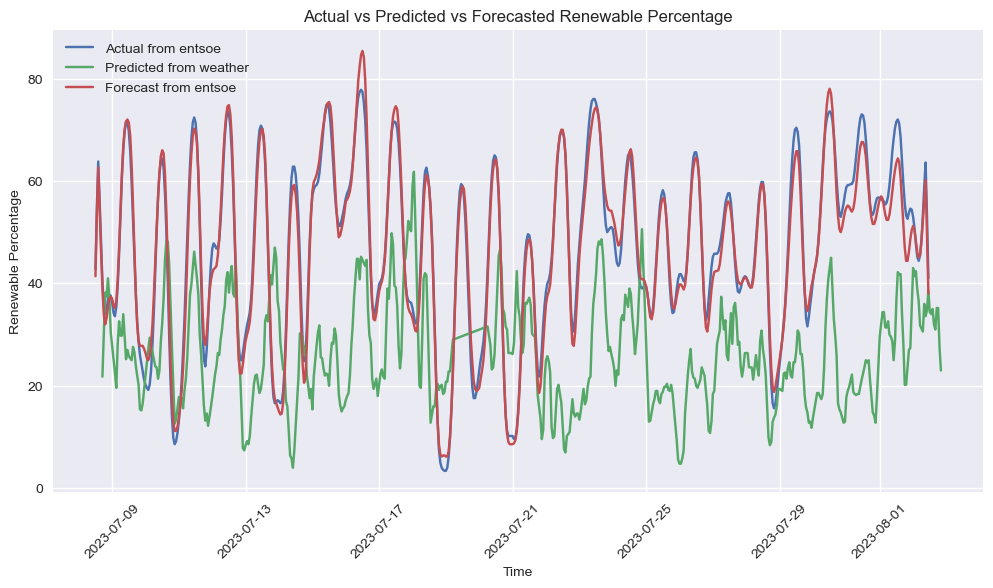

In [14]:
#load dataset
data = pd.read_csv('data/DE_weather_zip_code.csv') #historical weather data with the zip code
xdata=data.drop(columns='time')
ydata=pd.read_csv('data/DE_energy_generation_20220601-20230601.csv') #the renewable energy %

# Call the function to run the regression model
Germany_decision_regressor(xdata,ydata)


Validation MSE: 81.66834667046102
Test MSE: 75.51823773477517
Root Mean Squared Error: 8.69012299882891
R^2 Score: 0.7575269607396483
                        Feature  Importance
35       49windspeed_100m (m/s)    0.260318
45  84apparent_temperature (°C)    0.146429
20       21windspeed_100m (m/s)    0.060083
29       25windspeed_100m (m/s)    0.048653
21  23apparent_temperature (°C)    0.039172
Data will to be converted to 60 min interval


C:\Users\tory\Bionets\util.py:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  newGroupedData = oldData.groupby('group_id').mean()


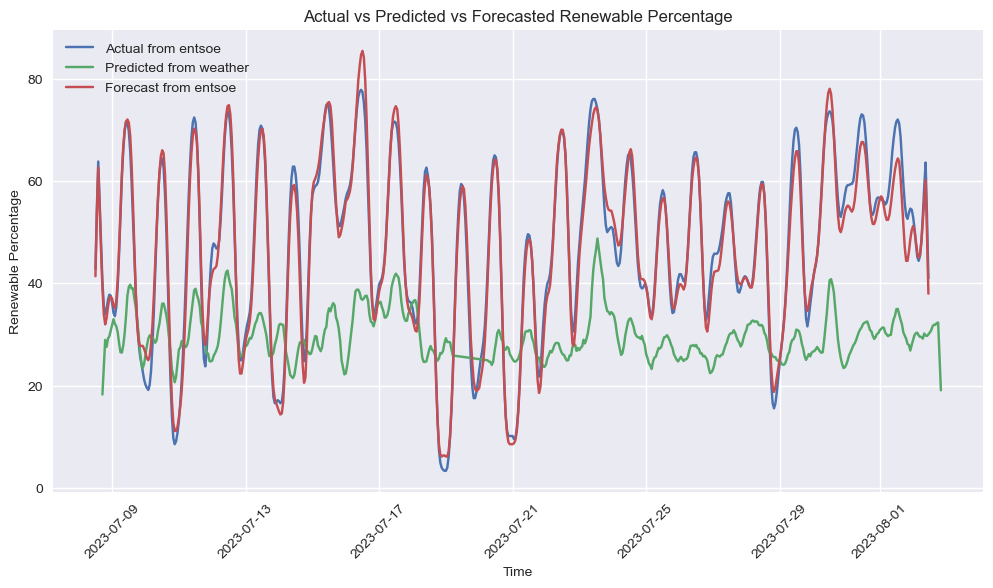

In [15]:
Germany_randomforest_regressor(xdata,ydata)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25692\3796075323.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


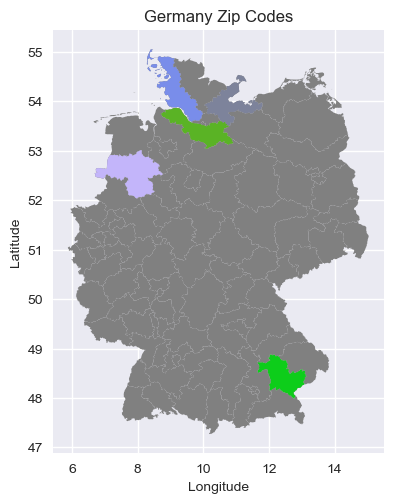

In [16]:

def zipcode_map():
    """
    plot zip code areas in Germany that affects the reneable energy % the most
    """
    plt.style.use('seaborn')
    %matplotlib inline

    # Load the shapefile containing Germany's zip code boundaries
    shapefile_path = "C:/Users/tory/Downloads/plz-2stellig.shp"
    zip_codes = gpd.read_file(shapefile_path)

    #top 5 locations
    powerplant_zip_codes = ['21', '23', '25', '49', '84']

    # Create a color mapping dictionary
    color_mapping = {}
    for zip_code in powerplant_zip_codes:
        color_mapping[zip_code] = '#' + ''.join(random.choice('0123456789ABCDEF') for _ in range(6))

    # Plot all zip code boundaries
    zip_codes.plot(color='gray')

    # Plot the highlighted zip code boundaries with auto-assigned colors
    for zip_code in powerplant_zip_codes:
        zip_code_df = zip_codes[zip_codes['plz'] == zip_code]
        zip_code_df.plot(ax=plt.gca(), color=color_mapping[zip_code])

    # Customize the plot 
    plt.title("Germany Zip Codes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Display the plot
    plt.show()

# Call the function to generate the zip code map
zipcode_map()
